# Information Warfare
## Russia’s use of Twitter during the 2016 US Presidential Election
---

### Import libraries

In [1]:
import os
from collections import Counter

import numpy as np
import pandas as pd
import spacy

from plotly import tools
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.io as pio

from IPython.display import Image

from helpers.io_data import ImportData

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', None)
get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""

init_notebook_mode(connected=True)

### Import data

In [2]:
# All Tweets
portfolio_data_bucket = os.getenv("PORTFOLIO_DATA_BUCKET")

five_38_data_retrieval = ImportData(
    bucket=portfolio_data_bucket,
    prefix="disinformation-project/raw-data"
)

df = five_38_data_retrieval\
        .retrieve_objects()\
        .return_dataframe()

# Filter to include only English tweets
dfEng = df[df.language == "English"]

# Filter to include only non-English tweets
dfOth = df[df.language != "English"]

## Inspect data

There are two sets of labels the Clemson researchers created: account type and account category. This project focuses on the account category label. 

**Note:** The labeling method employed by the Clemson researchers allows for accounts that primarily tweet in English to be labeled with a *Non-English* account category. For example, an account that primarily tweets about international events, such as the war in Ukraine, would be labeled as Non-English, even if the text is in English.

In [3]:
df.head()

,external_author_id,author,content,region,language,publish_date,harvested_date,following,followers,updates,post_type,account_type,retweet,account_category,new_june_2018,alt_external_id,tweet_id,article_url,tco1_step1,tco2_step1,tco3_step1
0,906000000000000000,10_GOP,"""We have a sitting Democrat US Senator on tria...",Unknown,English,10/1/2017 19:58,10/1/2017 19:59,1052,9636,253,NaN,Right,0,RightTroll,0,905874659358453760,914580356430536707,http://twitter.com/905874659358453760/statuses...,https://twitter.com/10_gop/status/914580356430...,NaN,NaN
1,906000000000000000,10_GOP,Marshawn Lynch arrives to game in anti-Trump s...,Unknown,English,10/1/2017 22:43,10/1/2017 22:43,1054,9637,254,NaN,Right,0,RightTroll,0,905874659358453760,914621840496189440,http://twitter.com/905874659358453760/statuses...,https://twitter.com/damienwoody/status/9145685...,NaN,NaN
2,906000000000000000,10_GOP,Daughter of fallen Navy Sailor delivers powerf...,Unknown,English,10/1/2017 22:50,10/1/2017 22:51,1054,9637,255,RETWEET,Right,1,RightTroll,0,905874659358453760,914623490375979008,http://twitter.com/905874659358453760/statuses...,https://twitter.com/10_gop/status/913231923715...,NaN,NaN
3,906000000000000000,10_GOP,JUST IN: President Trump dedicates Presidents ...,Unknown,English,10/1/2017 23:52,10/1/2017 23:52,1062,9642,256,NaN,Right,0,RightTroll,0,905874659358453760,914639143690555392,http://twitter.com/905874659358453760/statuses...,https://twitter.com/10_gop/status/914639143690...,NaN,NaN
4,906000000000000000,10_GOP,"19,000 RESPECTING our National Anthem! #StandF...",Unknown,English,10/1/2017 2:13,10/1/2017 2:13,1050,9645,246,RETWEET,Right,1,RightTroll,0,905874659358453760,914312219952861184,http://twitter.com/905874659358453760/statuses...,https://twitter.com/realDonaldTrump/status/914...,NaN,NaN


In [4]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2946207 entries, 0 to 233539
Data columns (total 21 columns):
 #   Column              Non-Null Count    Dtype 
---  ------              --------------    ----- 
 0   external_author_id  2946207 non-null  object
 1   author              2946207 non-null  object
 2   content             2946206 non-null  object
 3   region              2937389 non-null  object
 4   language            2946207 non-null  object
 5   publish_date        2946207 non-null  object
 6   harvested_date      2946207 non-null  object
 7   following           2946207 non-null  int64 
 8   followers           2946207 non-null  int64 
 9   updates             2946207 non-null  int64 
 10  post_type           1297582 non-null  object
 11  account_type        2946207 non-null  object
 12  retweet             2946207 non-null  int64 
 13  account_category    2946207 non-null  object
 14  new_june_2018       2946207 non-null  int64 
 15  alt_external_id     2946207 non-n

---
**All tweets:** Observations, Unique Authors, Account Types, and Account categories

In [5]:
summary = (
    f"Full Data Set: \n {df.shape[0]:,} observations \n\n"
    f"Unique authors: {df.author.nunique():,}\n\n"
    f"Account types: {df.account_type.unique()}\n\n"
    f"Account categories: {df.account_category.unique()}"
)

print(summary)

Full Data Set: 
 2,946,207 observations 

Unique authors: 2,843

Account types: ['Right' 'Russian' 'Koch' 'Italian' 'Left' '?' 'German' 'Spanish'
 'Hashtager' 'Arabic' 'local' 'Commercial' 'French' 'Ukranian' 'news'
 'Ebola ' 'Portuguese' 'ZAPOROSHIA' 'Uzbek']

Account categories: ['RightTroll' 'NonEnglish' 'Fearmonger' 'LeftTroll' 'Unknown'
 'HashtagGamer' 'NewsFeed' 'Commercial']


---
**English tweets:** Observations, Unique Authors, Account Types, and Account categories

In [6]:
summary = (
    f"Full Data Set: \n {dfEng.shape[0]:,} observations \n\n"
    f"Unique authors: {dfEng.author.nunique():,}\n\n"
    f"Account types: {dfEng.account_type.unique()}\n\n"
    f"Account categories: {dfEng.account_category.unique()}"
)
print(summary)

Full Data Set: 
 2,116,867 observations 

Unique authors: 2,161

Account types: ['Right' 'Koch' 'Italian' 'Russian' 'Left' '?' 'German' 'Hashtager'
 'Arabic' 'local' 'Commercial' 'French' 'news' 'Ebola ' 'Portuguese'
 'ZAPOROSHIA' 'Spanish']

Account categories: ['RightTroll' 'Fearmonger' 'NonEnglish' 'LeftTroll' 'Unknown'
 'HashtagGamer' 'NewsFeed' 'Commercial']


---
**Non-English tweets:** Observations, Unique Authors, Account Types, and Account categories

In [7]:
summary = (
    f"Full Data Set: \n {dfOth.shape[0]:,} observations \n\n"
    f"Unique authors: {dfOth.author.nunique():,}\n\n"
    f"Account types: {dfOth.account_type.unique()}\n\n"
    f"Account categories: {dfOth.account_category.unique()}"
)
print(summary)

Full Data Set: 
 829,340 observations 

Unique authors: 2,360

Account types: ['Russian' 'Koch' 'Italian' 'Right' 'Left' '?' 'German' 'Spanish'
 'Hashtager' 'Arabic' 'local' 'Commercial' 'French' 'Ukranian' 'news'
 'Portuguese' 'ZAPOROSHIA' 'Uzbek' 'Ebola ']

Account categories: ['NonEnglish' 'Fearmonger' 'RightTroll' 'LeftTroll' 'Unknown'
 'HashtagGamer' 'NewsFeed' 'Commercial']


---
Additional exploration of non-english dataset

In [8]:
summary = (
    f"Non-english: Counts per Account Category \n\n{Counter(dfOth.account_category)}\n\n"
    f"Unique Languages: {dfOth.language.nunique():,}"
    f"Median # of languages per account:{dfOth.groupby('author')['language'].nunique().median()}\n\n"
    f"Accounts with english and non-english tweets:"
    f" {pd.Series(dfOth.author.unique()).isin(dfEng.author.unique()).sum():,}"
)

print(summary)

Non-english: Counts per Account Category 

Counter({'NonEnglish': 794241, 'Commercial': 9324, 'RightTroll': 6715, 'Unknown': 6594, 'HashtagGamer': 5694, 'LeftTroll': 5000, 'NewsFeed': 1633, 'Fearmonger': 139})

Unique Languages: 55Median # of languages per account:5.0

Accounts with english and non-english tweets: 1,678


## Number of Tweets by Account Category (All Tweets)

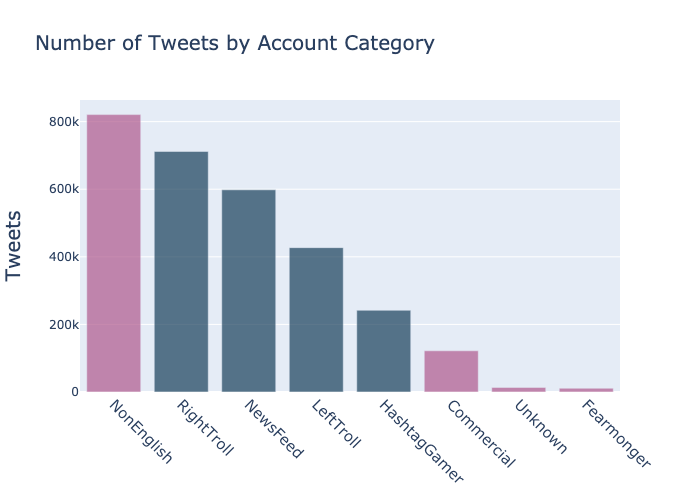

In [9]:
counts_by_type_A = dict(Counter(df.account_category))

account_type_A = list(counts_by_type_A.keys())
values_A = list(counts_by_type_A.values())

account_type_A = [x for _,x in sorted(zip(values_A ,account_type_A), reverse = True)]
values_A = sorted(values_A, reverse = True)

other_color = ['Unknown', 'Commercial', 'NonEnglish', 'Fearmonger']

color_list = ['rgb(175, 88, 141)' if i in other_color else 'rgb(23,62,90)' for i in account_type_A]

data = [go.Bar(
            x=account_type_A,
            y=values_A,
            marker = dict(color = color_list),
            opacity = .7
    )]

layout = go.Layout(title = dict(text = 'Number of Tweets by Account Category', font = dict(size = 20)), 
                   xaxis = dict(
                       tickangle = 45, 
                       tickfont = dict(size = 15),
                       automargin = True),
                  yaxis = dict(title = dict(text = 'Tweets', font = dict(size = 20))))

fig = go.Figure(data = data, layout = layout)

img_bytes = pio.to_image(fig, format='png')
Image(img_bytes)

# py.iplot(fig, filename='basic-bar')

## Number of Tweets by Account Category (English language Tweets)

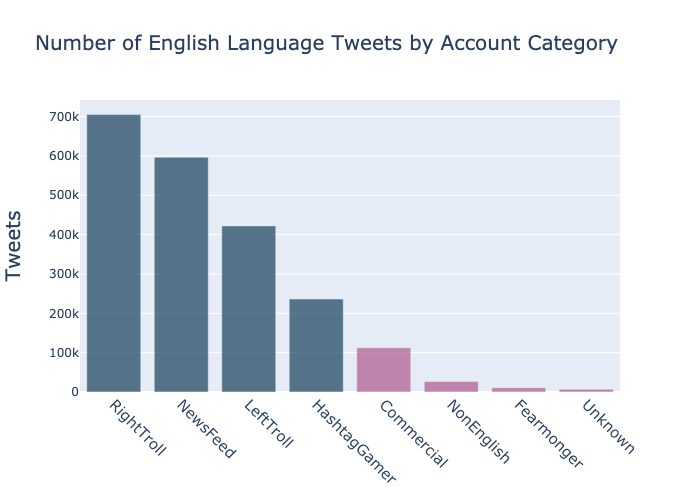

In [10]:
counts_by_type_B = dict(Counter(dfEng.account_category))

account_type_B = list(counts_by_type_B.keys())
values_B = list(counts_by_type_B.values())

account_type_B = [x for _,x in sorted(zip(values_B ,account_type_B), reverse = True)]
values_B = sorted(values_B, reverse = True)

other_color = ['Unknown', 'Commercial', 'NonEnglish', 'Fearmonger']

color_list = ['rgb(175, 88, 141)' if i in other_color else 'rgb(23,62,90)' for i in account_type_B]

data = [go.Bar(
            x=account_type_B,
            y=values_B,
            marker = dict(color = color_list),
            opacity = .7
    )]

layout = go.Layout(title = dict(text = 'Number of English Language Tweets by Account Category', font = dict(size = 20)), 
                   xaxis = dict(
                       tickangle = 45, 
                       tickfont = dict(size = 15),
                       automargin = True),
                  yaxis = dict(title = dict(text = 'Tweets', font = dict(size = 20))))

fig = go.Figure(data = data, layout = layout)

img_bytes = pio.to_image(fig, format='png')
Image(img_bytes)

# py.iplot(fig, filename='basic-bar')

## Number of Tweets by Account Category (Non-English Language Tweets)

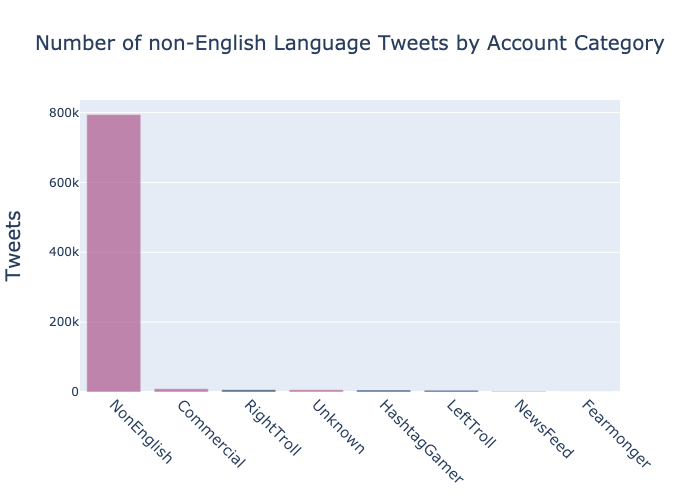

In [11]:
counts_by_type_C = dict(Counter(dfOth.account_category))

account_type_C = list(counts_by_type_C.keys())
values_C = list(counts_by_type_C.values())

account_type_C = [x for _,x in sorted(zip(values_C ,account_type_C), reverse = True)]
values_C = sorted(values_C, reverse = True)

other_color = ['Unknown', 'Commercial', 'NonEnglish', 'Fearmonger']

color_list = ['rgb(175, 88, 141)' if i in other_color else 'rgb(23,62,90)' for i in account_type_C]

data = [go.Bar(
            x=account_type_C,
            y=values_C,
            marker = dict(color = color_list),
            opacity = .7
    )]

layout = go.Layout(title = dict(text = 'Number of non-English Language Tweets by Account Category', font = dict(size = 20)), 
                   xaxis = dict(
                       tickangle = 45, 
                       tickfont = dict(size = 15),
                       automargin = True),
                  yaxis = dict(title = dict(text = 'Tweets', font = dict(size = 20))))

fig = go.Figure(data = data, layout = layout)

img_bytes = pio.to_image(fig, format='png')
Image(img_bytes)

# py.iplot(fig, filename='basic-bar')

### Number of Tweets by Account Category (English vs Non-English)

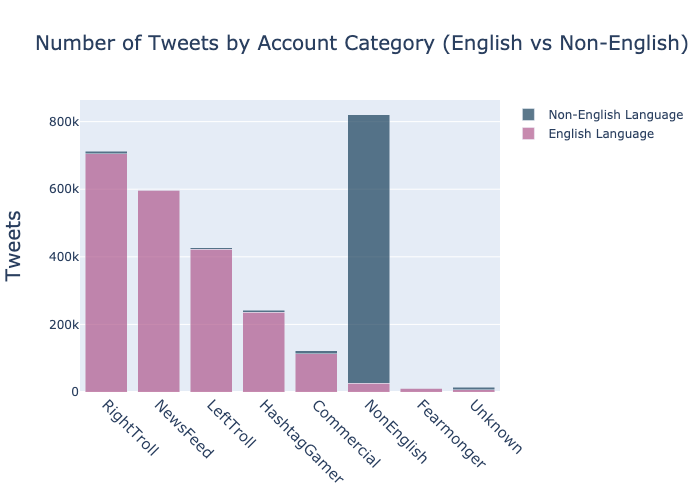

In [12]:
trace1 = go.Bar(
    x = account_type_B,
    y = values_B,
    name ='English Language',
    marker=dict(color='rgb(175, 88, 141)'),
    opacity = .7
)

trace2 = go.Bar(
    x=account_type_C,
    y=values_C,
    name='Non-English Language',
    marker=dict(color='rgb(23,62,90)'),
    opacity = .7
)

data = [trace1, trace2]

layout = go.Layout(
    title = dict(text = 'Number of Tweets by Account Category (English vs Non-English)', font = dict(size = 20)),
    xaxis = dict(
        tickangle = 45, 
        tickfont = dict(size = 15),
        automargin = True),
    yaxis = dict(title = dict(text = 'Tweets', font = dict(size = 20))),
    barmode='stack'
)

fig = go.Figure(data=data, layout=layout)

img_bytes = pio.to_image(fig, format='png')
Image(img_bytes)

# py.iplot(fig, filename='bar2.html')

---
### Number of Accounts by Account Category

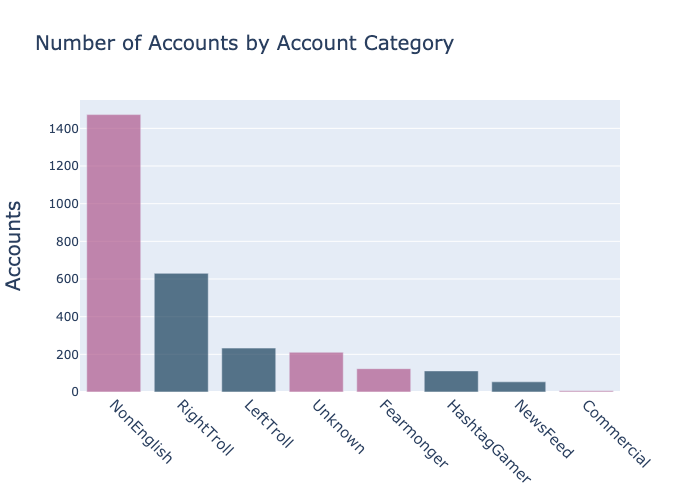

In [13]:
account_analysis_D = df.groupby(['author', 'account_category'])['content'].count().reset_index()

account_analysis_D = Counter(account_analysis_D.account_category)

account_type_D = list(account_analysis_D.keys())
values_D = list(account_analysis_D.values())

account_type_D = [x for _,x in sorted(zip(values_D ,account_type_D), reverse = True)]
values_D = sorted(values_D, reverse = True)

color_list = ['rgb(175, 88, 141)' if i in other_color else 'rgb(23,62,90)' for i in account_type_D]

data = [go.Bar(
            x=account_type_D,
            y=values_D,
            marker = dict(color = color_list),
            opacity = .7
    )]

layout = go.Layout(title = dict(text = 'Number of Accounts by Account Category', font = dict(size = 20)), 
                   xaxis = dict(
                       tickangle = 45, 
                       tickfont = dict(size = 15),
                       automargin = True),
                  yaxis = dict(title = dict(text = 'Accounts', font = dict(size = 20))))

fig = go.Figure(data = data, layout = layout)
img_bytes = pio.to_image(fig, format='png')
Image(img_bytes)

# py.iplot(fig, filename='bar2.html')

### Number of English Language Accounts by Account Category

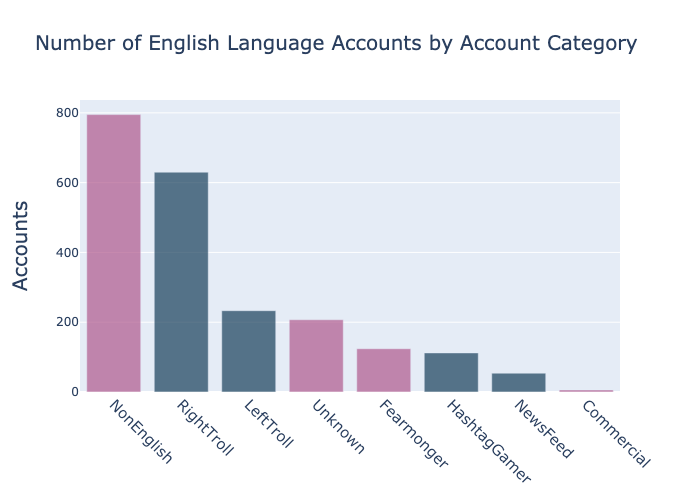

In [14]:
account_analysis_E = dfEng.groupby(['author', 'account_category'])['content'].count().reset_index()

account_analysis_E = Counter(account_analysis_E.account_category)

account_type_E = list(account_analysis_E.keys())
values_E = list(account_analysis_E.values())

account_type_E = [x for _,x in sorted(zip(values_E ,account_type_E), reverse = True)]
values_E = sorted(values_E, reverse = True)

color_list = ['rgb(175, 88, 141)' if i in other_color else 'rgb(23,62,90)' for i in account_type_E]

data = [go.Bar(
            x=account_type_E,
            y=values_E,
            marker = dict(color = color_list),
            opacity = .7
    )]

layout = go.Layout(title = dict(text = 'Number of English Language Accounts by Account Category', font = dict(size = 20)), 
                   xaxis = dict(
                       tickangle = 45, 
                       tickfont = dict(size = 15),
                       automargin = True),
                  yaxis = dict(title = dict(text = 'Accounts', font = dict(size = 20))))

fig = go.Figure(data = data, layout = layout)
img_bytes = pio.to_image(fig, format='png')
Image(img_bytes)

# py.iplot(fig, filename='bar2.html')

### Number of non-English Language Accounts by Account Category

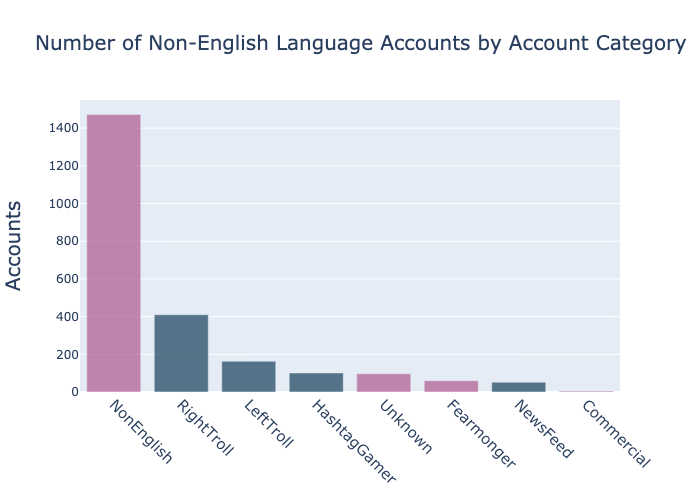

In [15]:
account_analysis_F = dfOth.groupby(['author', 'account_category'])['content'].count().reset_index()

account_analysis_F = Counter(account_analysis_F.account_category)

account_type_F = list(account_analysis_F.keys())
values_F = list(account_analysis_F.values())

account_type_F = [x for _,x in sorted(zip(values_F ,account_type_F), reverse = True)]
values_F = sorted(values_F, reverse = True)

color_list = ['rgb(175, 88, 141)' if i in other_color else 'rgb(23,62,90)' for i in account_type_F]

data = [go.Bar(
            x=account_type_F,
            y=values_F,
            marker = dict(color = color_list),
            opacity = .7
    )]

layout = go.Layout(title = dict(text = 'Number of Non-English Language Accounts by Account Category', font = dict(size = 20)), 
                   xaxis = dict(
                       tickangle = 45, 
                       tickfont = dict(size = 15),
                       automargin = True),
                  yaxis = dict(title = dict(text = 'Accounts', font = dict(size = 20))))

fig = go.Figure(data = data, layout = layout)
img_bytes = pio.to_image(fig, format='png')
Image(img_bytes)

# py.iplot(fig, filename='bar2.html')

### Number of Accounts by Account Category (English vs Non-English)

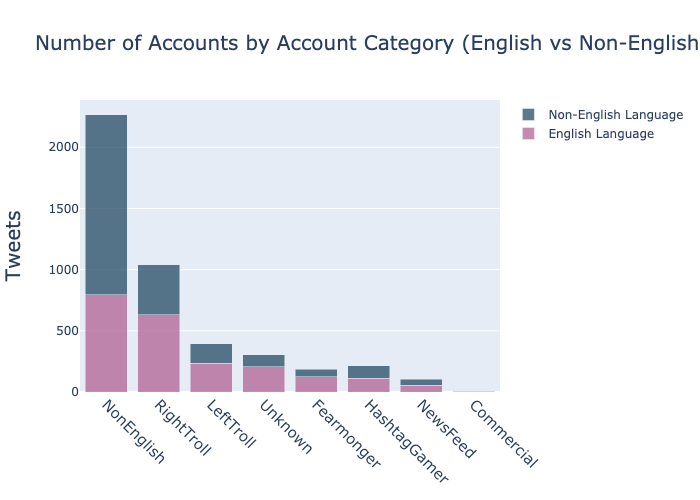

In [16]:
trace3 = go.Bar(
    x = account_type_E,
    y = values_E,
    name ='English Language',
    marker=dict(color='rgb(175, 88, 141)'),
    opacity = .7
)

trace4 = go.Bar(
    x=account_type_F,
    y=values_F,
    name='Non-English Language',
    marker=dict(color='rgb(23,62,90)'),
    opacity = .7
)

data = [trace3, trace4]

layout = go.Layout(
    title = dict(text = 'Number of Accounts by Account Category (English vs Non-English)', font = dict(size = 20)),
    xaxis = dict(
        tickangle = 45, 
        tickfont = dict(size = 15),
        automargin = True),
    yaxis = dict(title = dict(text = 'Tweets', font = dict(size = 20))),
    barmode='stack'
)

fig = go.Figure(data=data, layout=layout)
img_bytes = pio.to_image(fig, format='png')
Image(img_bytes)

# py.iplot(fig, filename='bar2.html')

---
### Determine number of accounts with more than set number of Tweets

For our procedure to work, we need to make sure that we have enough information (tweets) for each account for doc2vec to appropriatly embed our text in a vector space. As such, we need to ensure that we only consider accounts that meet some threshold for a minimum number of tweets, which we we do below. 

It should be noted that the choice of 400 tweets is arbitraryl by setting this threshold, the amount of non-English accounts in the dataset has decreased considerably. 

In [16]:
# Let's get counts of the number of tweets by each author
counts_by_author = df[['author', 'content']].groupby('author').count()
counts_by_author.reset_index(inplace = True)

print('Number of accounts with more than 400 tweets:', sum(counts_by_author.content > 400))

author_series = counts_by_author.author[counts_by_author.content > 400]
df = df[df.author.isin(author_series)]

# English language Tweets
counts_by_author = dfEng[['author', 'content']].groupby('author').count()
counts_by_author.reset_index(inplace = True)

print('Number of English language accounts with more than 400 tweets:', sum(counts_by_author.content > 400))

author_series = counts_by_author.author[counts_by_author.content > 400]
dfEng = dfEng[dfEng.author.isin(author_series)]

# Non-English language Tweets
counts_by_author = dfOth[['author', 'content']].groupby('author').count()
counts_by_author.reset_index(inplace = True)

print('Number of non-English language accounts with more than 400 tweets:', sum(counts_by_author.content > 400))

author_series = counts_by_author.author[counts_by_author.content > 400]
dfOth = dfOth[dfOth.author.isin(author_series)]

Number of accounts with more than 400 tweets: 1138
Number of English language accounts with more than 400 tweets: 463
Number of non-English language accounts with more than 400 tweets: 678


### All accounts with more than 400 Tweets

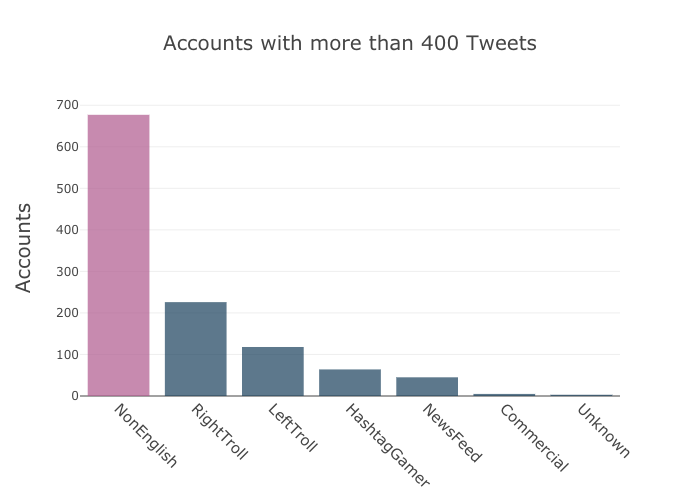

In [17]:
account_analysis = df.groupby(['author', 'account_category'])['content'].count().reset_index()
account_analysis = Counter(account_analysis.account_category)

account_type = list(account_analysis.keys())
values = list(account_analysis.values())

account_type_G = [x for _,x in sorted(zip(values ,account_type), reverse = True)]
values_G = sorted(values, reverse = True)

color_list = ['rgb(175, 88, 141)' if i == 'NonEnglish' else 'rgb(23,62,90)' for i in account_type]

data = [go.Bar(
            x=account_type_G,
            y=values_G,
            marker = dict(color = color_list),
            opacity = .7
    )]

layout = go.Layout(title = dict(text = 'Accounts with more than 400 Tweets', font = dict(size = 20)), 
                   xaxis = dict(
                       tickangle = 45, 
                       tickfont = dict(size = 15),
                       automargin = True),
                  yaxis = dict(title = dict(text = 'Accounts', font = dict(size = 20))))

fig = go.Figure(data = data, layout = layout)
img_bytes = pio.to_image(fig, format='png')
Image(img_bytes)

# py.iplot(fig, filename='bar2.html')

### English Language accounts with more than 400 Tweets

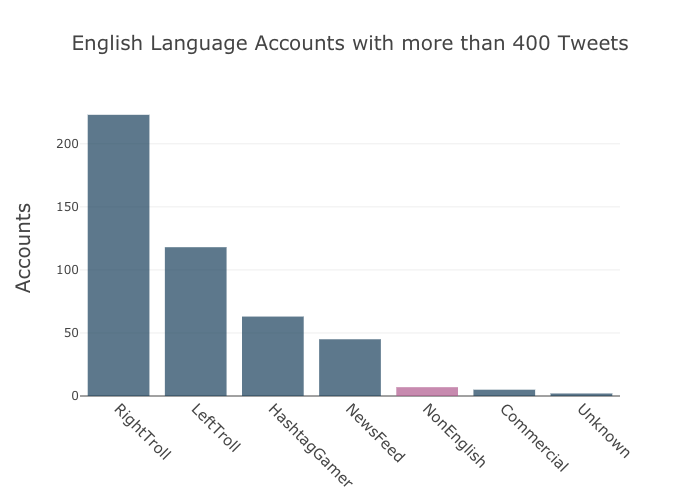

In [18]:
account_analysis = dfEng.groupby(['author', 'account_category'])['content'].count().reset_index()
account_analysis = Counter(account_analysis.account_category)

account_type = list(account_analysis.keys())
values = list(account_analysis.values())

account_type_H = [x for _,x in sorted(zip(values ,account_type), reverse = True)]
values_H = sorted(values, reverse = True)

color_list = ['rgb(175, 88, 141)' if i == 'NonEnglish' else 'rgb(23,62,90)' for i in account_type]

data = [go.Bar(
            x=account_type_H,
            y=values_H,
            marker = dict(color = color_list),
            opacity = .7
    )]

layout = go.Layout(title = dict(text = 'English Language Accounts with more than 400 Tweets', font = dict(size = 20)), 
                   xaxis = dict(
                       tickangle = 45, 
                       tickfont = dict(size = 15),
                       automargin = True),
                  yaxis = dict(title = dict(text = 'Accounts', font = dict(size = 20))))

fig = go.Figure(data = data, layout = layout)
img_bytes = pio.to_image(fig, format='png')
Image(img_bytes)

# py.iplot(fig, filename='bar2.html')

### Non-English Language Accounts with more than 400 Tweets

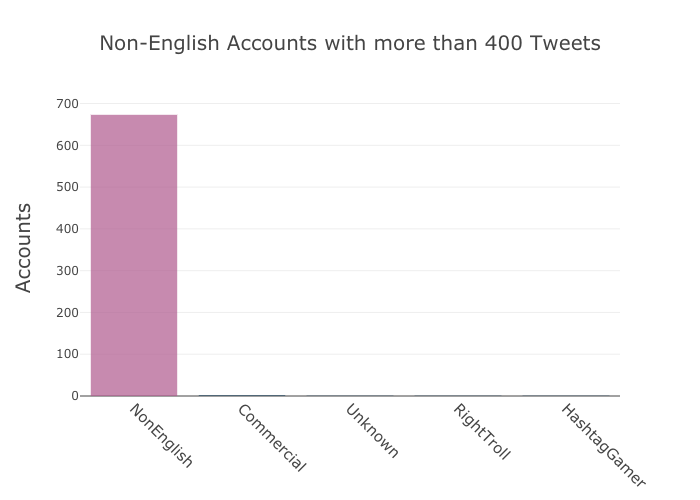

In [19]:
account_analysis = dfOth.groupby(['author', 'account_category'])['content'].count().reset_index()
account_analysis = Counter(account_analysis.account_category)

account_type = list(account_analysis.keys())
values = list(account_analysis.values())

account_type_I = [x for _,x in sorted(zip(values ,account_type), reverse = True)]
values_I = sorted(values, reverse = True)

color_list = ['rgb(175, 88, 141)' if i == 'NonEnglish' else 'rgb(23,62,90)' for i in account_type]

data = [go.Bar(
            x=account_type_I,
            y=values_I,
            marker = dict(color = color_list),
            opacity = .7
    )]

layout = go.Layout(title = dict(text = 'Non-English Accounts with more than 400 Tweets', font = dict(size = 20)), 
                   xaxis = dict(
                       tickangle = 45, 
                       tickfont = dict(size = 15),
                       automargin = True),
                  yaxis = dict(title = dict(text = 'Accounts', font = dict(size = 20))))

fig = go.Figure(data = data, layout = layout)
img_bytes = pio.to_image(fig, format='png')
Image(img_bytes)

# py.iplot(fig, filename='bar2.html')

### Accounts with more than 400 Tweets (English vs Non-English)

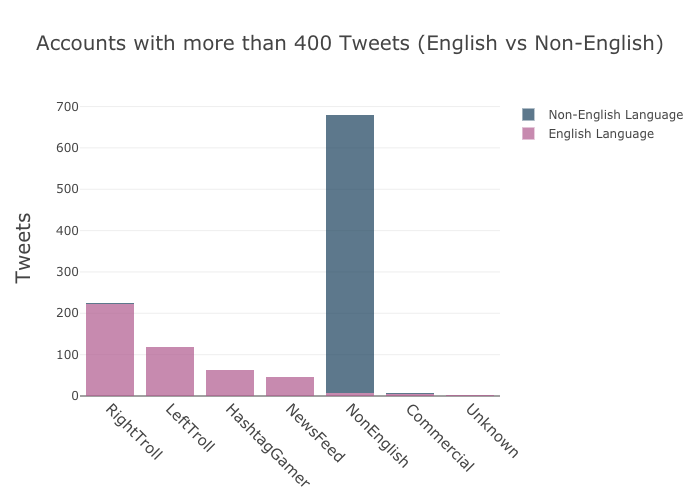

In [20]:
trace5 = go.Bar(
    x = account_type_H,
    y = values_H,
    name ='English Language',
    marker=dict(color='rgb(175, 88, 141)'),
    opacity = .7
)

trace6 = go.Bar(
    x=account_type_I,
    y=values_I,
    name='Non-English Language',
    marker=dict(color='rgb(23,62,90)'),
    opacity = .7
)

data = [trace5, trace6]

layout = go.Layout(
    title = dict(text = 'Accounts with more than 400 Tweets (English vs Non-English)', font = dict(size = 20)),
    xaxis = dict(
        tickangle = 45, 
        tickfont = dict(size = 15),
        automargin = True),
    yaxis = dict(title = dict(text = 'Tweets', font = dict(size = 20))),
    barmode='stack'
)

fig = go.Figure(data=data, layout=layout)
img_bytes = pio.to_image(fig, format='png')
Image(img_bytes)

# py.iplot(fig, filename='bar2.html')